# Electric Arc Furnace - Análisis y Predicción

# 1. Configuración del Entorno y Gestión de Rutas




En esta sección cargamos las herramientas necesarias para todo el ciclo de vida del proyecto, desde la adquisición de datos hasta el entrenamiento de modelos de Machine Learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import kagglehub
import shutil
from pathlib import Path
import warnings

c:\Users\js834\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


En esta sección, establecemos la infraestructura lógica del proyecto.

* **Estandarización**: Creamos la siguiente jerarquía de carpetas:
    * `raw`: Datos originales (inmutables).
    * `processed`: Datos limpios listos para modelado.
    * `models`: Almacenamiento de metadatos y archivos `.joblib`.
    
* **Automatización**: El script verifica la existencia de estas carpetas y las crea si es necesario para evitar errores de ejecución.

In [2]:
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'    # Ruta para datos sin procesar
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed' # Ruta para datos procesados
MODELS_DIR = PROJECT_ROOT / 'models'    # Ruta para guardar modelos entrenados

# Crear directorios si no existen
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_RAW: {DATA_RAW}")
print(f"DATA_PROCESSED: {DATA_PROCESSED}")
print(f"MODELS_DIR: {MODELS_DIR}")
print("\nConfiguración completada.")

PROJECT_ROOT: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final
DATA_RAW: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final\data\raw
DATA_PROCESSED: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final\data\processed
MODELS_DIR: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final\models

Configuración completada.


# 2. Carga de Datos y Limpieza Automatizada

Esta sección automatiza la adquisición y preparación inicial de los datos. Se divide en tres etapas críticas para asegurar que el análisis posterior sea fluido y libre de errores de formato.

### Procesos Clave:
1. **Adquisición Automatizada**: Se conecta con la API de Kaggle para descargar el dataset original (`industrial-data-from-the-arc-furnace`) solo si los archivos no están presentes localmente. Esto garantiza que cualquier colaborador tenga acceso inmediato a los datos.
2. **Estandarización de Esquemas**: Se transforman todos los nombres de columnas a minúsculas y se reemplazan espacios por guiones bajos (`_`). Esto evita errores comunes de escritura al acceder a las variables.
3. **Limpieza de Tipos de Datos (Formato Europeo)**: El dataset original presenta números con comas (decimales europeos). Implementamos una limpieza básica que detecta estas columnas, reemplaza las comas por puntos y convierte los valores a formato numérico (`float/int`) automáticamente.
4. **Organización en Memoria**: Los datos se cargan en un diccionario y se asignan a variables individuales descriptivas (`df_transformer`, `df_temp`, etc.) para facilitar su manipulación en las siguientes secciones.

In [3]:
# =============================================================================
# DESCARGA AUTOMÁTICA DESDE KAGGLE (si data/raw está vacía)
# =============================================================================
KAGGLE_DATASET = "yuriykatser/industrial-data-from-the-arc-furnace"

ARCHIVOS_PRINCIPALES = [    # Lista de archivos CSV principales esperados
    "eaf_transformer.csv",
    "eaf_gaslance_mat.csv",
    "inj_mat.csv",
    "ladle_tapping.csv",
    "eaf_temp.csv",
    "eaf_final_chemical_measurements.csv"
]

# Verificar si la carpeta está vacía o faltan archivos
archivos_existentes = list(DATA_RAW.glob('*.csv'))
faltan_archivos = not archivos_existentes or any(
    not (DATA_RAW / f).exists() for f in ARCHIVOS_PRINCIPALES
)

if faltan_archivos:
    print(f"Descargando dataset desde Kaggle: {KAGGLE_DATASET}...")
    cached_path = Path(kagglehub.dataset_download(KAGGLE_DATASET))
    
    # Copiar archivos al directorio raw
    for archivo in cached_path.glob('*.csv'):
        shutil.copy2(archivo, DATA_RAW / archivo.name)
    
    print(f"Descarga completada. Archivos en: {DATA_RAW}")
else:
    print(f"Datos ya disponibles en: {DATA_RAW}")

print(f"Archivos CSV encontrados: {len(list(DATA_RAW.glob('*.csv')))}")

# =============================================================================
# CARGA INTELIGENTE CON LIMPIEZA BÁSICA
# =============================================================================
print("\n" + "="*60)
print("CARGANDO ARCHIVOS CSV PRINCIPALES")
print("="*60)

dataframes = {}

# Cargar cada archivo CSV con limpieza básica
for archivo in ARCHIVOS_PRINCIPALES:
    filepath = DATA_RAW / archivo
    
    if not filepath.exists():
        print(f"ADVERTENCIA: {archivo} no encontrado, saltando...")
        continue
    
    # Cargar CSV
    df = pd.read_csv(filepath, low_memory=False)
    
    # Estandarizar nombres de columnas: minúsculas y sin espacios
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    
    # Limpieza al vuelo: formato europeo de decimales (coma -> punto)
    for col in df.select_dtypes(include=['object']).columns:
        # Detectar columnas con formato europeo (ej: "123,45")
        sample = df[col].dropna().head(100).astype(str)
        if sample.str.match(r'^-?\d+,\d+$').any():
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Nombre de variable: sin extensión y con guiones bajos
    nombre_var = archivo.replace('.csv', '').replace('-', '_')
    dataframes[nombre_var] = df
    
    print(f"  {archivo:<45} -> {df.shape[0]:>7,} filas x {df.shape[1]:>3} cols")

# =============================================================================
# ASIGNAR A VARIABLES INDIVIDUALES PARA FACILITAR USO
# =============================================================================
df_transformer = dataframes.get('eaf_transformer')
df_gaslance = dataframes.get('eaf_gaslance_mat')
df_injection = dataframes.get('inj_mat')
df_ladle = dataframes.get('ladle_tapping')
df_temp = dataframes.get('eaf_temp')
df_chemical = dataframes.get('eaf_final_chemical_measurements')

print("\n" + "="*60)
print("PREPROCESAMIENTO COMPLETADO")
print("="*60)
print(f"DataFrames cargados: {list(dataframes.keys())}")
print("\nVariables disponibles:")
print("  - df_transformer  : Datos del transformador eléctrico")
print("  - df_gaslance     : Datos de lanza de gas/oxígeno")
print("  - df_injection    : Datos de inyección de materiales")
print("  - df_ladle        : Datos de cuchara (tapping)")
print("  - df_temp         : Mediciones de temperatura")
print("  - df_chemical     : Mediciones químicas finales")

Datos ya disponibles en: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final\data\raw
Archivos CSV encontrados: 11

CARGANDO ARCHIVOS CSV PRINCIPALES
  eaf_transformer.csv                           -> 271,712 filas x   5 cols
  eaf_gaslance_mat.csv                          -> 5,748,194 filas x   6 cols
  inj_mat.csv                                   -> 4,011,646 filas x   4 cols
  ladle_tapping.csv                             -> 115,873 filas x   5 cols
  eaf_temp.csv                                  ->  85,104 filas x   4 cols
  eaf_final_chemical_measurements.csv           ->   3,709 filas x  15 cols

PREPROCESAMIENTO COMPLETADO
DataFrames cargados: ['eaf_transformer', 'eaf_gaslance_mat', 'inj_mat', 'ladle_tapping', 'eaf_temp', 'eaf_final_chemical_measurements']

Variables disponibles:
  - df_transformer  : Datos del transformador eléctrico
  - df_gaslance     : Datos de lanza de gas/oxígeno
  - df_injection    :

# 3. Construcción del Dataset Maestro: Agregación de Variables por Colada

### Construcción del Dataset Maestro: Agregación de Variables por Colada

En esta etapa, transformamos los datos transaccionales (múltiples registros por evento) en un **Dataset Maestro Estático**. El objetivo es tener una única fila por cada `heatid` (colada), consolidando toda la información relevante del proceso de fundición.

### Transformaciones Realizadas:
1. **Cálculo de Energía**: Convertimos la potencia (`mw`) y duración (`MM:SS`) en Energía Consumida (`MWh`). Esto es crítico, ya que la energía es el principal factor que influye en la temperatura final.
2. **Consumo de Gases y Carbón**: Extraemos el último valor acumulado de oxígeno, gas y carbono inyectado para cada colada, representando el total utilizado al final del proceso.
3. **Gestión de Materiales y Cargas**: 
    * Calculamos el peso total de la carga.
    * Realizamos un **Pivoteo (One-Hot Encoding manual)** de los 10 materiales más frecuentes. Esto permite que el modelo entienda qué aditivos específicos se usaron en cada colada.
4. **Fusión (Merge) Secuencial**: Integramos todas las fuentes en un único DataFrame (`df_master`), asegurando que no se pierda información de ninguna etapa y gestionando los valores nulos para mantener la integridad del dataset.

In [4]:
# =============================================================================
# 1. DATASET MAESTRO - VARIABLES ESTÁTICAS POR COLADA
# =============================================================================
print("="*60)
print("CONSTRUYENDO DATASET MAESTRO (VARIABLES ESTÁTICAS)")
print("="*60)

# -----------------------------------------------------------------------------
# 1.1 Energía del transformador (mw * duración en minutos)
# -----------------------------------------------------------------------------
df_trans = df_transformer.copy()

# Parsear duración "MM:SS" a minutos
df_trans['duration_min'] = df_trans['duration'].apply(
    lambda x: float(str(x).split(':')[0]) + float(str(x).split(':')[1])/60 
    if pd.notna(x) and ':' in str(x) else 0
)
df_trans['mw'] = pd.to_numeric(df_trans['mw'], errors='coerce').fillna(0)
df_trans['energy_mwh'] = df_trans['mw'] * df_trans['duration_min'] / 60

grp_energy = df_trans.groupby('heatid').agg(
    total_energy=('energy_mwh', 'sum'),
    total_duration_min=('duration_min', 'sum')
).reset_index()

print(f"  Energía agregada: {len(grp_energy)} coladas")

# -----------------------------------------------------------------------------
# 1.2 Gases (O2 y gas) - último valor acumulado por colada
# -----------------------------------------------------------------------------
df_gas = df_gaslance.copy()
df_gas['o2_amount'] = pd.to_numeric(df_gas['o2_amount'], errors='coerce')
df_gas['gas_amount'] = pd.to_numeric(df_gas['gas_amount'], errors='coerce')

# Detectar columna de tiempo
col_time_gas = [c for c in df_gas.columns if 'time' in c.lower()][0]
df_gas[col_time_gas] = pd.to_datetime(df_gas[col_time_gas].astype(str).str.replace(',', '.'), errors='coerce')
df_gas = df_gas.sort_values(['heatid', col_time_gas])

grp_gas = df_gas.groupby('heatid').agg(
    total_o2=('o2_amount', 'last'),
    total_gas=('gas_amount', 'last')
).reset_index()

print(f"  Gases agregados: {len(grp_gas)} coladas")

# -----------------------------------------------------------------------------
# 1.3 Inyección de carbón - último valor acumulado
# -----------------------------------------------------------------------------
df_inj = df_injection.copy()
df_inj['inj_amount_carbon'] = pd.to_numeric(df_inj['inj_amount_carbon'], errors='coerce')

col_time_inj = [c for c in df_inj.columns if 'time' in c.lower()][0]
df_inj[col_time_inj] = pd.to_datetime(df_inj[col_time_inj].astype(str).str.replace(',', '.'), errors='coerce')
df_inj = df_inj.sort_values(['heatid', col_time_inj])

grp_carbon = df_inj.groupby('heatid').agg(
    total_carbon=('inj_amount_carbon', 'last')
).reset_index()

print(f"  Carbón agregado: {len(grp_carbon)} coladas")

# -----------------------------------------------------------------------------
# 1.4 Materiales (ladle) - carga total + pivot top 10 materiales
# -----------------------------------------------------------------------------
df_mat = df_ladle.copy()
df_mat['charge_amount'] = pd.to_numeric(df_mat['charge_amount'], errors='coerce').fillna(0)

# Carga total por colada
grp_charge = df_mat.groupby('heatid').agg(
    total_charge=('charge_amount', 'sum')
).reset_index()

# Pivot: top 10 materiales más frecuentes
top_10_materials = df_mat['mat_code'].value_counts().head(10).index.tolist()
df_mat_top = df_mat[df_mat['mat_code'].isin(top_10_materials)]

pivot_materials = df_mat_top.pivot_table(
    index='heatid',
    columns='mat_code',
    values='charge_amount',
    aggfunc='sum',
    fill_value=0
).add_prefix('mat_').reset_index()

print(f"  Materiales: {len(grp_charge)} coladas, {len(top_10_materials)} tipos pivotados")

# -----------------------------------------------------------------------------
# 1.5 Fusión en df_master
# -----------------------------------------------------------------------------
# Base: todos los heatids únicos
all_heatids = set(grp_energy['heatid']) | set(grp_gas['heatid']) | set(grp_carbon['heatid'])
df_master = pd.DataFrame({'heatid': list(all_heatids)})

# Merge secuencial
df_master = df_master.merge(grp_energy, on='heatid', how='left')
df_master = df_master.merge(grp_gas, on='heatid', how='left')
df_master = df_master.merge(grp_carbon, on='heatid', how='left')
df_master = df_master.merge(grp_charge, on='heatid', how='left')
df_master = df_master.merge(pivot_materials, on='heatid', how='left')

# Rellenar nulos con 0
df_master = df_master.fillna(0)

print(f"\n  df_master: {df_master.shape[0]} coladas x {df_master.shape[1]} features")
print(f"  Columnas: {df_master.columns.tolist()}")

CONSTRUYENDO DATASET MAESTRO (VARIABLES ESTÁTICAS)
  Energía agregada: 20813 coladas
  Gases agregados: 20827 coladas
  Carbón agregado: 20827 coladas
  Materiales: 20827 coladas, 10 tipos pivotados

  df_master: 20827 coladas x 17 features
  Columnas: ['heatid', 'total_energy', 'total_duration_min', 'total_o2', 'total_gas', 'total_carbon', 'total_charge', 'mat_140107', 'mat_202007', 'mat_202008', 'mat_202039', 'mat_202063', 'mat_203068', 'mat_203085', 'mat_205069', 'mat_360258', 'mat_705043']


### Construcción del Dataset Secuencial para Predicción de Temperatura

A diferencia del dataset maestro estático, este proceso genera un **dataset secuencial**. En la industria siderúrgica, se realizan múltiples mediciones de temperatura durante una misma colada (`heatid`). El objetivo aquí es preparar el modelo para que, dada una medición actual, sea capaz de predecir la **siguiente temperatura**.

1. **Detección Automática de Columnas**: El script identifica dinámicamente las columnas de temperatura, tiempo y oxidación, permitiendo cierta flexibilidad en el formato de entrada.
2. **Filtrado Físico**: Se eliminan registros fuera del rango lógico (1000°C - 1850°C) para descartar errores de lectura de los sensores o mediciones accidentales fuera del horno.
3. **Ingeniería de Variables Secuenciales**:
    * **`num_measurement`**: Contador de mediciones dentro de una misma colada.
    * **`time_since_start`**: Tiempo transcurrido en minutos desde la primera medición.
4. **Definición del Target (Variable Objetivo)**: 
    * Se utiliza una técnica de **desplazamiento (shift)** para que cada fila contenga la temperatura actual y el valor que se quiere predecir (`target_next_temp`), que es la temperatura de la siguiente medición.
    * Se calcula el `horizon_min`, que es el tiempo que transcurre entre la predicción y el evento real.
5. **Enriquecimiento**: Se fusiona la información secuencial con las variables estáticas del `df_master` (energía, materiales, gases) para que el modelo tenga el contexto completo de lo que ha ocurrido en el horno hasta ese momento.

In [5]:
# =============================================================================
# 2. DATASET SECUENCIAL - TEMPERATURA
# =============================================================================
print("\n" + "="*60)
print("CONSTRUYENDO DATASET SECUENCIAL (TEMPERATURA)")
print("="*60)

df_t = df_temp.copy()

# Detectar columnas
col_temp = [c for c in df_t.columns if 'temp' in c.lower() and 'time' not in c.lower()][0]
col_time = [c for c in df_t.columns if 'time' in c.lower() or 'date' in c.lower()][0]
col_ox = [c for c in df_t.columns if 'ox' in c.lower()]
col_ox = col_ox[0] if col_ox else None

print(f"  Columna temperatura: {col_temp}")
print(f"  Columna tiempo: {col_time}")

# Convertir tipos
df_t[col_temp] = pd.to_numeric(df_t[col_temp], errors='coerce')
df_t[col_time] = pd.to_datetime(df_t[col_time].astype(str).str.replace(',', '.'), errors='coerce')
if col_ox:
    df_t[col_ox] = pd.to_numeric(df_t[col_ox], errors='coerce')

# Filtrar rango válido (1000-1850 °C)
n_inicial = len(df_t)
df_t = df_t[(df_t[col_temp] >= 1000) & (df_t[col_temp] <= 1850)].copy()
print(f"  Filtro 1000-1850°C: {n_inicial:,} -> {len(df_t):,} filas")

# Eliminar nulos y ordenar
df_t = df_t.dropna(subset=['heatid', col_time, col_temp])
df_t = df_t.sort_values(['heatid', col_time]).reset_index(drop=True)

# Features secuenciales
df_t['temp_actual'] = df_t[col_temp]
df_t['oxidation'] = df_t[col_ox].fillna(0) if col_ox else 0
df_t['num_measurement'] = df_t.groupby('heatid').cumcount() + 1
df_t['time_since_start'] = df_t.groupby('heatid')[col_time].transform(
    lambda x: (x - x.min()).dt.total_seconds() / 60
)

# Target: temperatura siguiente (shift -1 dentro de cada colada)
df_t['target_next_temp'] = df_t.groupby('heatid')[col_temp].shift(-1)
df_t['datetime_next'] = df_t.groupby('heatid')[col_time].shift(-1)
df_t['horizon_min'] = (df_t['datetime_next'] - df_t[col_time]).dt.total_seconds() / 60

# Limpiar bordes (última medición de cada colada no tiene target)
df_t = df_t.dropna(subset=['target_next_temp'])
df_t = df_t[(df_t['horizon_min'] > 0) & (df_t['horizon_min'] < 120)]

print(f"  Filas con target válido: {len(df_t):,}")

# Fusionar con df_master
df_temp_final = df_t.merge(df_master, on='heatid', how='left').fillna(0)

# Seleccionar columnas finales (eliminar auxiliares)
cols_drop = [col_temp, col_time, 'datetime_next']
if col_ox and col_ox in df_temp_final.columns:
    cols_drop.append(col_ox)
df_temp_final = df_temp_final.drop(columns=[c for c in cols_drop if c in df_temp_final.columns])

# Guardar
df_temp_final.to_csv(DATA_PROCESSED / 'dataset_final_temp.csv', index=False)
print(f"\n  Guardado: dataset_final_temp.csv")
print(f"  Shape: {df_temp_final.shape}")



CONSTRUYENDO DATASET SECUENCIAL (TEMPERATURA)
  Columna temperatura: temp
  Columna tiempo: datetime
  Filtro 1000-1850°C: 85,104 -> 85,104 filas
  Filas con target válido: 59,714

  Guardado: dataset_final_temp.csv
  Shape: (59714, 24)


### Construcción del Dataset para Predicción de Composición Química

Este proceso consolida la información necesaria para predecir la calidad química final del acero. A diferencia de la temperatura, la química se trata como un problema estático por colada, donde el objetivo es predecir la concentración de diversos elementos (Carbono, Silicio, Manganeso, etc.) al final del proceso en el horno de arco eléctrico (EAF).

1. **Extracción y Renombrado de Objetivos (Targets)**: Se identifican las mediciones finales de elementos químicos y se les asigna el prefijo `target_` para diferenciarlos claramente de las variables de entrada.
2. **Integración de Mediciones Iniciales**: Se cargan los datos de química inicial (`lf_initial_chemical_measurements.csv`). Estas son variables críticas, ya que la composición final depende directamente del estado inicial de la carga y la chatarra.
3. **Limpieza Rigurosa de Outliers y Valores Centinela**:
    * **Valores Centinela**: Se eliminan valores imposibles (ej. $\geq 100\%$) que suelen ser códigos de error del sistema de laboratorio.
    * **Filtros Estadísticos**: Se detectan valores extremos mediante percentiles para asegurar que el modelo no aprenda de mediciones erróneas o ruidosas.
4. **Consolidación del Dataset Químico**:
    * Se realiza un `inner join` con el `df_master` para asegurar que solo trabajamos con coladas que tienen datos de proceso (energía, materiales) y resultados químicos.
    * Se incorporan los valores iniciales mediante un `left join`.
5. **Tratamiento de Datos Faltantes**: Se rellenan con `0` solo las variables de entrada (features), manteniendo los valores nulos en los objetivos para no introducir sesgos artificiales en el entrenamiento.

In [6]:
# =============================================================================
# 3. DATASET ESTÁTICO - QUÍMICA
# =============================================================================
print("\n" + "="*60)
print("CONSTRUYENDO DATASET ESTÁTICO (QUÍMICA)")
print("="*60)

df_chem = df_chemical.copy()

# Extraer columnas target (empiezan por 'val')
target_cols = [c for c in df_chem.columns if c.startswith('val')]
print(f"  Targets químicos encontrados: {target_cols}")

# Convertir a numérico
for col in target_cols:
    df_chem[col] = pd.to_numeric(df_chem[col], errors='coerce')

# Seleccionar heatid + targets, eliminar duplicados
df_targets = df_chem[['heatid'] + target_cols].drop_duplicates(subset=['heatid'], keep='last')

# Renombrar con prefijo target_
df_targets = df_targets.rename(columns={c: f'target_{c}' for c in target_cols})

# -----------------------------------------------------------------------------
# CARGAR MEDICIONES QUÍMICAS INICIALES
# -----------------------------------------------------------------------------
print("\n  Cargando mediciones químicas iniciales...")
df_chem_inicial = pd.read_csv(DATA_RAW / 'lf_initial_chemical_measurements.csv', low_memory=False)
df_chem_inicial.columns = df_chem_inicial.columns.str.lower().str.strip()

# Columnas de valores iniciales
init_cols = ['valc', 'valsi', 'valmn', 'valp', 'vals', 'valcu', 'valcr', 'valmo', 'valni']

# Convertir a numérico (formato europeo coma -> punto)
for col in init_cols:
    if col in df_chem_inicial.columns:
        df_chem_inicial[col] = df_chem_inicial[col].astype(str).str.replace(',', '.', regex=False)
        df_chem_inicial[col] = pd.to_numeric(df_chem_inicial[col], errors='coerce')

# Tomar primera medición por colada y renombrar con prefijo init_
df_init = df_chem_inicial.groupby('heatid')[init_cols].first().reset_index()
df_init = df_init.rename(columns={c: f'init_{c}' for c in init_cols})

print(f"  Valores iniciales: {len(df_init)} coladas, {len(init_cols)} elementos")

# -----------------------------------------------------------------------------
# LIMPIEZA DE OUTLIERS EN TARGETS QUÍMICOS (CRÍTICO)
# -----------------------------------------------------------------------------
print("\n  Limpieza de outliers:")
target_renamed = [f'target_{c}' for c in target_cols]

for col in target_renamed:
    # 1. Reemplazar valores centinela (>=100 es imposible para % químico)
    mask_centinela = df_targets[col] >= 100
    n_centinela = mask_centinela.sum()
    if n_centinela > 0:
        df_targets.loc[mask_centinela, col] = np.nan
        print(f"    {col}: {n_centinela} valores centinela (>=100) -> NaN")
    
    # 2. Filtrar outliers extremos (> percentil 99.5)
    p995 = df_targets[col].quantile(0.995)
    if p995 > 0 and p995 < 10:  # Solo si tiene sentido
        mask_outlier = df_targets[col] > p995 * 3  # 3x el P99.5
        n_outlier = mask_outlier.sum()
        if n_outlier > 0:
            df_targets.loc[mask_outlier, col] = np.nan
            print(f"    {col}: {n_outlier} outliers extremos -> NaN")

# Fusionar con df_master (inner join: solo coladas con datos completos)
df_chem_final = df_master.merge(df_targets, on='heatid', how='inner')

# Fusionar con valores iniciales
df_chem_final = df_chem_final.merge(df_init, on='heatid', how='left')

# Rellenar NaN con 0 SOLO en features, no en targets
feature_cols_chem = [c for c in df_chem_final.columns if not c.startswith('target_') and c != 'heatid']
df_chem_final[feature_cols_chem] = df_chem_final[feature_cols_chem].fillna(0)

# Guardar
df_chem_final.to_csv(DATA_PROCESSED / 'dataset_final_chemical.csv', index=False)
print(f"\n  Guardado: dataset_final_chemical.csv")
print(f"  Shape: {df_chem_final.shape}")

# Verificación de targets limpios
print("\n  Verificación de targets (después de limpieza):")
for col in target_renamed[:3]:  # Mostrar solo los primeros 3
    data = df_chem_final[col].dropna()
    print(f"    {col}: mean={data.mean():.4f}, std={data.std():.4f}, max={data.max():.4f}")

# Verificación de valores iniciales
print("\n  Valores iniciales añadidos:")
init_renamed = [f'init_{c}' for c in init_cols]
print(f"    Columnas: {init_renamed}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETADO")
print("="*60)
print(f"  df_master:            {df_master.shape[0]:>6,} coladas x {df_master.shape[1]:>3} features")
print(f"  dataset_final_temperature:  {df_temp_final.shape[0]:>6,} filas   x {df_temp_final.shape[1]:>3} features")
print(f"  dataset_chemical:     {df_chem_final.shape[0]:>6,} coladas x {df_chem_final.shape[1]:>3} features")
print(f"\nArchivos guardados en: {DATA_PROCESSED}")


CONSTRUYENDO DATASET ESTÁTICO (QUÍMICA)
  Targets químicos encontrados: ['valc', 'valsi', 'valmn', 'valp', 'vals', 'valcu', 'valcr', 'valmo', 'valni', 'valas', 'valsn', 'valn']

  Cargando mediciones químicas iniciales...
  Valores iniciales: 20827 coladas, 9 elementos

  Limpieza de outliers:
    target_valc: 1 valores centinela (>=100) -> NaN
    target_valsi: 5 outliers extremos -> NaN
    target_valp: 4 outliers extremos -> NaN
    target_valn: 4 outliers extremos -> NaN

  Guardado: dataset_final_chemical.csv
  Shape: (3709, 38)

  Verificación de targets (después de limpieza):
    target_valc: mean=0.0705, std=0.0270, max=0.4236
    target_valsi: mean=0.0191, std=0.0049, max=0.1246
    target_valmn: mean=0.1048, std=0.0401, max=0.7136

  Valores iniciales añadidos:
    Columnas: ['init_valc', 'init_valsi', 'init_valmn', 'init_valp', 'init_vals', 'init_valcu', 'init_valcr', 'init_valmo', 'init_valni']

FEATURE ENGINEERING COMPLETADO
  df_master:            20,827 coladas x  17 fe

# 4. Modelado de Predicción de Temperatura con XGBoost

En esta sección desarrollamos el modelo predictivo de regresión para la temperatura. El objetivo es que el sistema aprenda la relación compleja entre la energía aplicada, los materiales añadidos y la evolución térmica del acero líquido.

### Estrategias de Modelado:
1. **Prevención de Data Leakage (Fuga de datos)**: Utilizamos `GroupShuffleSplit`. En procesos industriales, una misma colada (`heatid`) tiene múltiples registros. Esta técnica garantiza que si una colada se usa para entrenar, el modelo nunca haya visto ninguna de sus mediciones al ser evaluado.
2. **Algoritmo XGBoost**: Seleccionamos *Extreme Gradient Boosting* por su excelente capacidad para manejar relaciones no lineales y su robustez frente a valores atípicos en variables de sensores.
3. **Métricas de Rendimiento**:
    * **RMSE (Error Cuadrático Medio)**: Nos indica la desviación típica de las predicciones en grados Celsius.
    * **MAE (Error Absoluto Medio)**: El error promedio esperado en cada predicción.
    * **$R^2$ (Coeficiente de Determinación)**: Proporción de la varianza de la temperatura explicada por el modelo.
4. **Validación de Overfitting**: Comparamos el rendimiento en entrenamiento vs. prueba para asegurar que el modelo sea capaz de generalizar a nuevas coladas y no solo memorizar los datos históricos.

In [7]:
# =============================================================================
# MODELO DE PREDICCIÓN DE TEMPERATURA - XGBoost
# =============================================================================
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

print("="*60)
print("MODELO DE TEMPERATURA - XGBOOST")
print("="*60)

# -----------------------------------------------------------------------------
# 1. CARGA DEL DATASET
# -----------------------------------------------------------------------------
df_temp_model = pd.read_csv(DATA_PROCESSED / 'dataset_final_temp.csv')
print(f"Dataset cargado: {df_temp_model.shape}")

# -----------------------------------------------------------------------------
# 2. LIMPIEZA FINAL
# -----------------------------------------------------------------------------
n_inicial = len(df_temp_model)

# Eliminar filas con target nulo
df_temp_model = df_temp_model.dropna(subset=['target_next_temp'])

# Filtrar horizonte temporal anómalo (> 120 min)
if 'horizon_min' in df_temp_model.columns:
    df_temp_model = df_temp_model[
        (df_temp_model['horizon_min'] > 0) & 
        (df_temp_model['horizon_min'] <= 120)
    ]

print(f"Limpieza: {n_inicial:,} -> {len(df_temp_model):,} filas")

# -----------------------------------------------------------------------------
# 3. PREPARACIÓN DE FEATURES Y TARGET
# -----------------------------------------------------------------------------
TARGET = 'target_next_temp'

# =============================================================================
# LISTA EDITABLE DE FEATURES - Modifica esta lista para cambiar las variables
# =============================================================================
FEATURES_TEMPERATURA = [
    'temp_actual',
    'oxidation',
    'num_measurement',
    'time_since_start',
    'horizon_min',
    'total_energy',
    'total_duration_min',
    'total_o2',
    'total_gas',
    'total_carbon',
    'total_charge',
    'mat_140107',
    'mat_202007',
    'mat_202008',
    'mat_202039',
    'mat_202063',
    'mat_203068',
    'mat_203085',
    'mat_205069',
    'mat_360258',
    'mat_705043',
]

X = df_temp_model[FEATURES_TEMPERATURA]
y = df_temp_model[TARGET]
groups = df_temp_model['heatid']

print(f"\nFeatures: {len(FEATURES_TEMPERATURA)}")
print(f"  {FEATURES_TEMPERATURA}")
print(f"Muestras: {len(X):,}")
print(f"Coladas únicas: {groups.nunique()}")

# -----------------------------------------------------------------------------
# 4. SPLIT TRAIN/TEST CON GROUPSHUFFLESPLIT (CRÍTICO)
# -----------------------------------------------------------------------------
# GroupShuffleSplit garantiza que todas las mediciones de una misma colada
# estén completamente en train O en test, nunca mezcladas.
# Esto evita DATA LEAKAGE temporal.

TEST_SIZE = 0.2
RANDOM_STATE = 42

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verificar que no hay coladas mezcladas
train_heats = set(groups.iloc[train_idx])
test_heats = set(groups.iloc[test_idx])
overlap = train_heats & test_heats

print(f"\nSplit Train/Test (GroupShuffleSplit):")
print(f"  Train: {len(X_train):>7,} muestras ({len(train_heats):,} coladas)")
print(f"  Test:  {len(X_test):>7,} muestras ({len(test_heats):,} coladas)")
print(f"  Coladas superpuestas: {len(overlap)} (debe ser 0)")

if len(overlap) > 0:
    print("  ADVERTENCIA: Data leakage detectado!")
else:
    print("  Sin data leakage por coladas mezcladas")

# -----------------------------------------------------------------------------
# 5. ENTRENAMIENTO DEL MODELO XGBOOST
# -----------------------------------------------------------------------------
HYPERPARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print(f"\nEntrenando XGBRegressor...")
print(f"Hiperparámetros: {HYPERPARAMS}")

model_temp = XGBRegressor(**HYPERPARAMS)
model_temp.fit(X_train, y_train)

print("Entrenamiento completado.")

# -----------------------------------------------------------------------------
# 6. PREDICCIÓN Y EVALUACIÓN
# -----------------------------------------------------------------------------
# Predicciones en train y test
y_pred_train = model_temp.predict(X_train)
y_pred_test = model_temp.predict(X_test)

# Métricas en TRAIN
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Métricas en TEST
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN")
print("="*60)
print(f"{'Métrica':<10} {'Train':>12} {'Test':>12}")
print("-"*36)
print(f"{'RMSE':<10} {rmse_train:>10.2f} °C {rmse_test:>10.2f} °C")
print(f"{'MAE':<10} {mae_train:>10.2f} °C {mae_test:>10.2f} °C")
print(f"{'R²':<10} {r2_train:>12.4f} {r2_test:>12.4f}")
print("="*60)

# Interpretación
print(f"\nR² Test: {r2_test:.4f}")
if r2_test > 0.8:
    print("Excelente capacidad predictiva.")
elif r2_test > 0.6:
    print("Buena capacidad predictiva.")
elif r2_test > 0.3:
    print("Capacidad predictiva moderada.")
else:
    print("Capacidad predictiva baja. Revisar features o hiperparámetros.")

# Detectar overfitting
if r2_train - r2_test > 0.15:
    print(f"\nADVERTENCIA: Posible overfitting (R² train - R² test = {r2_train - r2_test:.4f})")

# -----------------------------------------------------------------------------
# 7. GUARDAR MODELO
# -----------------------------------------------------------------------------
model_path = MODELS_DIR / 'model_temperature_xgboost.joblib'
joblib.dump(model_temp, model_path)
print(f"\nModelo guardado: {model_path}")

MODELO DE TEMPERATURA - XGBOOST
Dataset cargado: (59714, 24)
Limpieza: 59,714 -> 59,714 filas

Features: 21
  ['temp_actual', 'oxidation', 'num_measurement', 'time_since_start', 'horizon_min', 'total_energy', 'total_duration_min', 'total_o2', 'total_gas', 'total_carbon', 'total_charge', 'mat_140107', 'mat_202007', 'mat_202008', 'mat_202039', 'mat_202063', 'mat_203068', 'mat_203085', 'mat_205069', 'mat_360258', 'mat_705043']
Muestras: 59,714
Coladas únicas: 19556

Split Train/Test (GroupShuffleSplit):
  Train:  47,769 muestras (15,644 coladas)
  Test:   11,945 muestras (3,912 coladas)
  Coladas superpuestas: 0 (debe ser 0)
  Sin data leakage por coladas mezcladas

Entrenando XGBRegressor...
Hiperparámetros: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'n_jobs': -1}
Entrenamiento completado.

MÉTRICAS DE EVALUACIÓN
Métrica           Train         Test
------------------------------------
RMSE            16.39 °

# 5. Modelado de Predicción Química: Azufre (S)

En esta etapa desarrollamos un modelo específico para predecir la concentración final de **Azufre (S)** en el acero. El control del azufre es crítico en la metalurgia, ya que niveles elevados pueden afectar negativamente la ductilidad y tenacidad del producto final.

### Aspectos Clave del Modelo:
1. **Integración de Conocimiento de Proceso**: El modelo no solo utiliza variables de consumo (energía, gases), sino que incorpora la **química inicial** (`init_vals`, `init_valc`, etc.). Esto es fundamental porque el azufre final depende fuertemente de la carga inicial y de la capacidad de desulfuración del proceso.
2. **Preparación Robusta**: Se eliminan registros sin datos de laboratorio y se realiza una imputación de seguridad con ceros para las variables de entrada (materiales no añadidos o sensores sin lectura).
3. **Validación Visual (Scatter Plot)**: Además de las métricas numéricas, generamos un gráfico de dispersión "Real vs. Predicho". La cercanía de los puntos a la diagonal roja (predicción perfecta) nos permite evaluar visualmente la precisión y detectar posibles sesgos o desviaciones sistemáticas.
4. **Persistencia**: El modelo se guarda en formato `.joblib` para ser USADO posteriormente por el sistema de despliegue o el dashboard en tiempo real.

MODELO QUÍMICO - AZUFRE (S)
Dataset cargado: (3709, 38)

Features utilizadas: 25
  ['total_energy', 'total_duration_min', 'total_o2', 'total_gas', 'total_carbon', 'total_charge', 'mat_140107', 'mat_202007', 'mat_202008', 'mat_202039', 'mat_202063', 'mat_203068', 'mat_203085', 'mat_205069', 'mat_360258', 'mat_705043', 'init_valc', 'init_valsi', 'init_valmn', 'init_valp', 'init_vals', 'init_valcu', 'init_valcr', 'init_valmo', 'init_valni']

Muestras: 3341
Target (target_vals): media=0.0334, std=0.0117

Split Train/Test:
  Train: 2672 muestras
  Test:  669 muestras

Entrenando XGBRegressor para Azufre...
Entrenamiento completado.

MÉTRICAS - AZUFRE (S)
  RMSE:  0.006644
  MAE:   0.004874
  R²:    0.6787


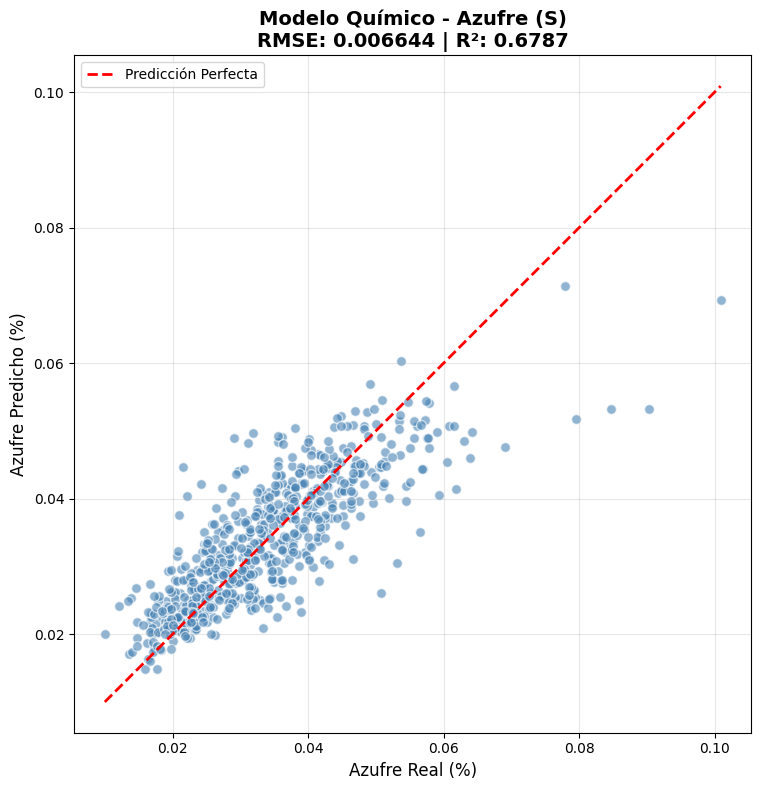


Modelo guardado: c:\Users\js834\OneDrive\Documentos\INGENIERÍA INFORMÁTICA\4º\1\Analítica de Datos para la Industria\Industria-Entrega-Final\models\model_chemical_sulfur_xgboost.joblib


In [8]:
# =============================================================================
# MODELO DE PREDICCIÓN QUÍMICA - AZUFRE (XGBoost)
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

print("="*60)
print("MODELO QUÍMICO - AZUFRE (S)")
print("="*60)

# -----------------------------------------------------------------------------
# 1. CARGA DEL DATASET
# -----------------------------------------------------------------------------
df_chem_model = pd.read_csv(DATA_PROCESSED / 'dataset_final_chemical.csv')
print(f"Dataset cargado: {df_chem_model.shape}")

# -----------------------------------------------------------------------------
# 2. DEFINICIÓN DEL TARGET
# -----------------------------------------------------------------------------
TARGET_CHEM = 'target_vals'  # Azufre (S)

# =============================================================================
# LISTA EDITABLE DE FEATURES - Modifica esta lista para cambiar las variables
# =============================================================================
FEATURES_QUIMICO = [
    # Variables del proceso
    'total_energy',
    'total_duration_min',
    'total_o2',
    'total_gas',
    'total_carbon',
    'total_charge',
    'mat_140107',
    'mat_202007',
    'mat_202008',
    'mat_202039',
    'mat_202063',
    'mat_203068',
    'mat_203085',
    'mat_205069',
    'mat_360258',
    'mat_705043',
    # Valores químicos iniciales
    'init_valc',
    'init_valsi',
    'init_valmn',
    'init_valp',
    'init_vals',
    'init_valcu',
    'init_valcr',
    'init_valmo',
    'init_valni',
]

print(f"\nFeatures utilizadas: {len(FEATURES_QUIMICO)}")
print(f"  {FEATURES_QUIMICO}")

# -----------------------------------------------------------------------------
# 3. PREPARACIÓN DE DATOS
# -----------------------------------------------------------------------------
# Eliminar filas donde el target es nulo
df_chem_model = df_chem_model.dropna(subset=[TARGET_CHEM])

X_chem = df_chem_model[FEATURES_QUIMICO].fillna(0)
y_chem = df_chem_model[TARGET_CHEM]

print(f"\nMuestras: {len(X_chem)}")
print(f"Target ({TARGET_CHEM}): media={y_chem.mean():.4f}, std={y_chem.std():.4f}")

# -----------------------------------------------------------------------------
# 4. SPLIT TRAIN/TEST
# -----------------------------------------------------------------------------
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_chem, y_chem, 
    test_size=0.2, 
    random_state=42
)

print(f"\nSplit Train/Test:")
print(f"  Train: {len(X_train_c)} muestras")
print(f"  Test:  {len(X_test_c)} muestras")

# -----------------------------------------------------------------------------
# 5. ENTRENAMIENTO
# -----------------------------------------------------------------------------
HYPERPARAMS_CHEM = {
    'n_estimators': 150,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

print(f"\nEntrenando XGBRegressor para Azufre...")
model_sulfur = XGBRegressor(**HYPERPARAMS_CHEM)
model_sulfur.fit(X_train_c, y_train_c)
print("Entrenamiento completado.")

# -----------------------------------------------------------------------------
# 6. PREDICCIÓN Y MÉTRICAS
# -----------------------------------------------------------------------------
y_pred_c = model_sulfur.predict(X_test_c)

rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
r2_c = r2_score(y_test_c, y_pred_c)
mae_c = mean_absolute_error(y_test_c, y_pred_c)

print("\n" + "="*60)
print("MÉTRICAS - AZUFRE (S)")
print("="*60)
print(f"  RMSE:  {rmse_c:.6f}")
print(f"  MAE:   {mae_c:.6f}")
print(f"  R²:    {r2_c:.4f}")
print("="*60)

# -----------------------------------------------------------------------------
# 7. VISUALIZACIÓN: VALORES REALES VS PREDICHOS
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(y_test_c, y_pred_c, alpha=0.6, c='steelblue', edgecolors='white', s=50)

# Línea de predicción perfecta (diagonal)
lims = [
    min(y_test_c.min(), y_pred_c.min()),
    max(y_test_c.max(), y_pred_c.max())
]
ax.plot(lims, lims, 'r--', linewidth=2, label='Predicción Perfecta')

# Configuración
ax.set_xlabel('Azufre Real (%)', fontsize=12)
ax.set_ylabel('Azufre Predicho (%)', fontsize=12)
ax.set_title(f'Modelo Químico - Azufre (S)\nRMSE: {rmse_c:.6f} | R²: {r2_c:.4f}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 8. GUARDAR MODELO
# -----------------------------------------------------------------------------
model_path_s = MODELS_DIR / 'model_chemical_sulfur_xgboost.joblib'
joblib.dump(model_sulfur, model_path_s)
print(f"\nModelo guardado: {model_path_s}")

# 6. Implementación: Dashboard en Streamlit y Servicio con BentoML

Este sistema integra una interfaz de usuario interactiva para la gestión del ciclo de vida de modelos de Machine Learning aplicados a un Horno de Arco Eléctrico (EAF).

### 1. Análisis Exploratorio de Datos (EDA) en Streamlit
El módulo de EDA (tab_eda.py) está diseñado para proporcionar una visión profunda y automatizada de los datasets de Temperatura y Composición Química antes de proceder al modelado.

* Estructura y Gestión de Datos
La implementación utiliza una carga de datos optimizada mediante un cached loader para garantizar que el dashboard sea fluido incluso con datasets de gran tamaño.

Multidataset: La pestaña procesa secuencialmente los datos de temperatura y química, adaptando los análisis según las características de cada uno (por ejemplo, detectando automáticamente las variables que comienzan con target_).

* Componentes del Análisis
El sistema de EDA se divide en cinco secciones clave:

- A. Resumen General y Estadísticas Descriptivas
Métricas de Salud del Dato: Se muestran indicadores rápidos sobre el número de filas, columnas, valores nulos totales y el consumo de memoria del dataset.

Perfilado Estadístico: Se integra un cuadro con la transpuesta de df.describe(), permitiendo revisar de un vistazo la media, desviación estándar y percentiles de todas las variables.

- B. Correlaciones con Variable Objetivo
Identificación de Predictores: Permite seleccionar dinámicamente la variable objetivo (como target_next_temp o componentes químicos) para visualizar qué variables tienen mayor impacto (positivo o negativo) mediante un gráfico de barras de correlación.

- C. Análisis de Distribución y Temporalidad
Visualización Dinámica: Implementa un selector dual que permite alternar entre:

Histogramas: Para observar la forma de la distribución y detectar posibles sesgos.

Series Temporales: Si se selecciona una columna de fecha, el sistema calcula y grafica la media diaria de la variable seleccionada para observar tendencias a lo largo del tiempo.

- D. Análisis Univariado Avanzado (Box Plots)
Detección de Outliers: Utiliza gráficos de caja (Box Plots) para identificar valores atípicos y la dispersión de los datos.

Métricas Detalladas: Se complementa el gráfico con tarjetas informativas que muestran los valores exactos de los cuartiles (Q1, Mediana, Q3) y los extremos (Min, Max).

- E. Análisis Multivariado (Heatmap)
Matriz de Interacción: Genera un mapa de calor interactivo que muestra la correlación de Pearson entre todas las variables numéricas del sistema, facilitando la identificación de colinealidad entre predictores.

Tecnologías de Visualización

La implementación destaca por:

- Plotly Express: Todos los gráficos son interactivos, permitiendo hacer zoom, filtrar series y consultar valores exactos al pasar el cursor (hover).

- Modularidad: Las funciones de graficación están desacopladas en dashboard.components.visualizations, lo que permite reutilizar la misma lógica visual en diferentes partes de la aplicación.

### 2. Fase de Entrenamiento
La funcionalidad de entrenamiento permite configurar y ejecutar nuevos modelos directamente desde la interfaz de Streamlit.

* Configuración Dinámica: El usuario puede seleccionar el tipo de algoritmo (XGBoost, Random Forest o Regresión Lineal) y definir hiperparámetros como el número de estimadores, la profundidad máxima y la tasa de aprendizaje mediante sliders.

* Selección de Variables: Permite elegir qué características (features) de entrada se utilizarán para el entrenamiento, filtrando automáticamente las variables objetivo para evitar sesgos.

* Ejecución y Persistencia: Al pulsar "Entrenar Modelo", se ejecutan las funciones del motor de modelos que entrenan el algoritmo, calculan métricas iniciales y guardan el modelo en formato .joblib junto con un archivo metadata.json que registra la configuración utilizada.

### 3. Fase de Evaluación
Una vez entrenados, los modelos pueden ser auditados visualmente para verificar su precisión antes de pasarlos a producción.

Explorador de Modelos: Streamlit escanea el directorio de modelos guardados y permite seleccionar cualquier versión previa para su análisis.

Visualización de Métricas: Se muestran indicadores clave de rendimiento como el RMSE (Error Cuadrático Medio), MAE (Error Absoluto Medio) y el coeficiente R².

Gráficos Interactivos:

- Importancia de Variables: Gráfico de barras que identifica qué factores influyen más en la predicción.

- Predicción vs. Real: Gráfico de dispersión para observar la desviación del modelo respecto a los datos reales.

- Distribución y Especificación: En modelos químicos, se analiza si las predicciones caen dentro de los rangos de tolerancia industrial.

### 4. Fase de Inferencia con BentoML
La inferencia se gestiona de forma profesional mediante un sistema de Model Serving que desacopla la predicción de la interfaz de usuario.

* Arquitectura de BentoML
Servicio REST: Se utiliza un servicio definido con @bentoml.service que expone un endpoint de API (/predict).

* Registro de Modelos: Antes de servir, el modelo seleccionado en Streamlit se registra en el almacén local de BentoML mediante comandos como bentoml.xgboost.save_model.

* Implementación en Streamlit (tab_inference.py)
Control del Ciclo de Vida: La interfaz permite iniciar y detener el servicio BentoML en segundo plano utilizando el módulo subprocess de Python, verificando constantemente si el puerto (3000 por defecto) está activo.

* Formularios Dinámicos: Streamlit lee los metadatos del modelo activo y genera automáticamente campos de entrada (st.number_input) solo para las variables que ese modelo específico requiere.

* Comunicación vía API: Las predicciones se solicitan enviando un JSON a la URL del servicio BentoML mediante la librería requests. El resultado se muestra en tiempo real con indicadores visuales de calidad (Verde/Amarillo/Rojo) según los rangos operativos del horno.

* Limpieza de Recursos: El sistema incluye una función de "limpieza" (cleanup_bentoml_service) que asegura que los procesos del servidor se cierren correctamente al salir de la aplicación para evitar fugas de memoria.